In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten 
from keras.layers import GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras import Sequential
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Reshape, Input
from keras.layers import Conv2DTranspose
from sklearn.manifold import TSNE

In [2]:
# Load cifar10 dataset
(x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Create dataset object from tensors and perform preprocessing
# Preprocessing steps involved are:
## cast tensors to float
## normalize images to values between 0 and 1
## one-hot encode labels
## zip input and labels
## batch dataset
## shuffle dataset
 
train_im = tf.data.Dataset.from_tensor_slices(x_train)

train_im = train_im.map(lambda img : tf.cast(img, tf.float32))
train_im = train_im.map(lambda img : img/255)
train_im = train_im.map(lambda img: tf.reshape(img, (28,28,1)))

tr_ds = train_im.batch(64)


#same for test set

test_im = tf.data.Dataset.from_tensor_slices(x_test)

test_im = test_im.map(lambda img : tf.cast(img, tf.float32))
test_im = test_im.map(lambda img : img/255)
test_im = train_im.map(lambda img: tf.reshape(img, (28,28,1)))


te_ds = test_im.batch(64)



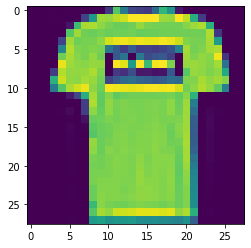

In [4]:
for i in tr_ds:
  plt.imshow(i[1,:,:,0])
  break

In [5]:
from keras import Model

class Encoder(Model): 
  def __init__(self): 
    super(Encoder, self).__init__()


    self.layers_list = [Conv2D(16, 3, padding='same', activation='relu'),
                        BatchNormalization(), 
                        MaxPooling2D(2),

                        Conv2D(32, 3, activation='relu', padding='same'),
                        BatchNormalization(), 

                        MaxPooling2D(2),
                        Conv2D(32, 3, activation='relu', padding='same'),
                        BatchNormalization(),
                        MaxPooling2D(2), 

                        Flatten(), 
                        Dense(10, activation='softmax')
                        ]


  def call(self, x):
    for i, layer in enumerate(self.layers_list):
      # print(tf.shape(x), '___',i)
      x = layer(x)
    # print(tf.shape(x), '___')

    return x



class Decoder(Model): 
  def __init__(self): 
    super(Decoder, self).__init__()

    self.layers_list = [Dense(49), 
                        Reshape((7,7,1)),
                        Conv2D(32, (3,3), padding='same', activation='relu'),
                        BatchNormalization(),
                        UpSampling2D((2,2)), 

                        Conv2D(64, (3,3), activation='relu', padding='same'),
                        BatchNormalization(),
                        UpSampling2D((2,2)), 

                        Conv2D(32 ,(3,3), activation='relu', padding='same'),
                        Conv2D(1, (3,3), activation='sigmoid', padding='same')
                        ]


  def call(self, x):
    for i, layer in enumerate(self.layers_list):
      # print(tf.shape(x), '___',i)
      x = layer(x)
    # print(tf.shape(x), '___',i)
    return x



In [6]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.layers_list= [Encoder(),
                       Decoder()]

  def call(self, x):
    for layer in self.layers_list:
      x = layer(x)

    return x

  def get_enc(self):
    return self.layers_list[0]


  def get_dec(self):
    return self.layers_list[1]



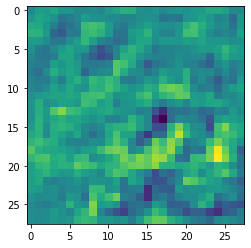

In [7]:
enc = Encoder()

dec = Decoder()
inp = tf.random.normal((28,28,1))
inp = tf.reshape(inp, (1,28,28,1))
#out = tf.constant([-0.23541524, -0.0633513 , -0.14792025, -0.49539533,  0.7927028 , 0.04283119,  0.02038066,  0.12454496], shape=(8,1))

res = dec(enc(inp))
plt.imshow(res[0,:,:,0])

In [8]:
# We use a dynamic learning rate which decays exponantially
# As an optimiser we use adam

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 
                                                    5000, 
                                                    0.97,
                                                    staircase=True)
opt = tf.optimizers.Adam(learning_rate=lr)

In [9]:
# model = DenseNet()

# model.compile(optimizer=opt, 
#              loss='categorical_crossentropy', 
#              metrics=['acc'])

# model.fit(tr_ds, validation_data=te_ds, epochs=30, shuffle=True)

In [10]:
# Training method returns mean loss and mean accuracy of the batch

def train(model, input, target, loss_f, optimizer): 
  with tf.GradientTape() as tape: 
    prediction = model(input)
    loss = loss_f(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  acc = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)


  return np.mean(loss.numpy()), np.mean(acc)


# Test method takes in whole test dataset and returns mean loss and mean accuracy on the whole test data
def test(model, test_data, loss_f): 
  test_acc = []
  test_loss = []
  #pred = None

  fig, axes = plt.subplots(10,2, figsize=(50,10))

  for i, input in enumerate(test_data): 
    prediction = model(input, training=False)
    loss = loss_f(input, prediction)
    loss = np.mean(loss.numpy())
    acc = np.argmax(input, axis=1) == np.argmax(prediction, axis=1)
    test_loss.append(loss)
    test_acc.append(np.mean(acc))
    if i < 10:
      axes[i,0].imshow(input[0,:,:,0], )
      axes[i,1].imshow(prediction[0,:,:,0])
  
  

  fin_loss = np.mean(np.array(test_loss))
  fin_acc = np.mean(test_acc)

  return fin_loss, fin_acc, axes

In [11]:
# Define additional hyperparameters

# Loss is categorical crossentropy
# The model will train for 30 epochs


tf.keras.backend.clear_session()

num_epochs = 20
learning_rate = 0.001
running_average_factor = 0.95


loss = tf.keras.losses.MSE

optimizer = opt

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
# Custom training loop
# Each epoch the model will learn on the shuffled and batched training data and will then evaluate the training step on the whole test dataset

model = AutoEncoder()
for epoch in range(num_epochs):
  print('Epoch:__' + str(epoch))

  tr_ds = tr_ds.shuffle(buffer_size=128).prefetch(2)
  te_ds = te_ds.shuffle(buffer_size=128).prefetch(2)


  running_average = 0
  batch_acc = []
  for input in tr_ds: 
    train_l, train_acc = train(model, input, input, loss, optimizer)
    running_average = (running_average_factor * running_average) + (1 - running_average_factor) * train_l
    batch_acc.append(train_acc)

  train_losses.append(running_average)
  train_accuracies.append(np.mean(batch_acc))
  print('Train losses: ', train_losses[-1])

  #testing
  test_loss, test_accu, axes = test(model, te_ds, loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accu)
  #axes.draw()
  print('Test loss: ', test_loss)
  print()


Epoch:__0
Train losses:  0.026924545333338237
Test loss:  0.027394159

Epoch:__1
Train losses:  0.02376269679719912
Test loss:  0.023766547

Epoch:__2
Train losses:  0.021958484768357
Test loss:  0.021619828

Epoch:__3
Train losses:  0.020581574005801007


In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
images = test_im.batch(1)
enc = model.get_enc()
encoded_images = []
for i, im in enumerate(images):
  encoded_images.append(enc(im))
  if i > 998:
    break



In [ ]:
print(encoded_images)

In [ ]:
encoded_ima = np.asarray(encoded_images)
encoded_ima = encoded_ima.squeeze()

In [ ]:
tee_schnirt = []
tsne = TSNE()
tee_schnirt.append(tsne.fit_transform(encoded_ima))

In [ ]:
y_test

In [ ]:
tee = np.asarray(tee_schnirt).squeeze()

In [ ]:
group = np.array([1,2,3,4,5,6,7,8,9,0])
cdict = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'black', 6: 'orange', 7: 'pink', 8: 'brown', 9: 'peru', 0: 'magenta'}
#ndict = {1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot', 0: 'T-Shirt/Top'}

# print(cdict[y_test[1]])
fig, ax = plt.subplots()
for i, data in enumerate(tee):
  # print(data)
  ax.scatter(data[0], data[1], c = cdict[y_test[i]], s = 50)
# ax.legend()
plt.show()